In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [2]:
torch.manual_seed(42)
np.random.seed(42)

#### Q4 (2)

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


In [4]:
def sigmoid(x):
    return 1.0 / (1.0 + torch.exp(-x))

def softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x), dim=0)

def cross_entropy(preds, targets):
    return -torch.sum(targets * torch.log(preds))

In [19]:
class NN:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.W1 = torch.randn(hidden_dim, input_dim) * 0.01
        self.W2 = torch.randn(output_dim, hidden_dim) * 0.01

    def forward(self, x):
        self.z1 = self.W1 @ x
        self.a1 = torch.sigmoid(self.z1)
        self.z2 = self.W2 @ self.a1
        self.y_hat = torch.nn.functional.softmax(self.z2, dim=0)
        return self.y_hat

    def backward(self, x, y, learning_rate=0.01):
        m = x.shape[1]

        dz2 = self.y_hat - y
        dW2 = dz2 @ self.a1.t() / m

        da1 = self.W2.t() @ dz2
        dz1 = da1 * self.a1 * (1 - self.a1)
        dW1 = dz1 @ x.t() / m

        self.W1 -= learning_rate * dW1
        self.W2 -= learning_rate * dW2


In [20]:
def model_test(model, dataset=testloader):
    correct_test = 0
    total_test = 0
    total_loss = 0
    for images, labels in dataset:
        images = images.view(images.shape[0], -1).t()
        labels_ = torch.eye(10)[:, labels]
        outputs = model.forward(images)
        predicted = torch.argmax(outputs, dim=0)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        total_loss += cross_entropy(outputs, labels_)
    test_accuracy = correct_test / total_test
    test_error = 1 - test_accuracy
    # print(f"Accuracy: {100 * test_accuracy}%, Test Error: {100 * test_error}%")
    total_loss = total_loss/len(dataset)
    return test_error, total_loss


In [21]:
learning_rate = 0.1
epochs = 50
input_dim = 28*28
hidden_dim = 300
output_dim = 10

model = NN(input_dim, hidden_dim, output_dim)

training_losses = []
test_losses = []
test_errors = []
for epoch in range(epochs):
    total_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1).t()
        labels = torch.eye(10)[:, labels]
        y_hat = model.forward(images)

        loss = cross_entropy(y_hat, labels)
        # loss = (-labels * torch.log(y_hat)).sum()
        total_loss += loss.item()

        model.backward(images, labels, learning_rate)
        
    training_losses.append(total_loss/len(trainloader))
    test_error, total_loss = model_test(model)
    test_losses.append(total_loss)
    test_errors.append(test_error)
    print(f"Epoch {epoch+1}, Loss: {training_losses[-1]}, Test Loss: {test_losses[-1]}, Test Error: {100 * test_error}%")

Epoch 1, Loss: 46.525045810731996, Test Loss: 21.8806209564209, Test Error: 9.950000000000003%
Epoch 2, Loss: 21.033095035979997, Test Loss: 18.991453170776367, Test Error: 8.940000000000003%
Epoch 3, Loss: 18.116923048297988, Test Loss: 16.4254150390625, Test Error: 7.599999999999996%
Epoch 4, Loss: 15.962472803811275, Test Loss: 14.434486389160156, Test Error: 6.689999999999996%
Epoch 5, Loss: 14.150173857776341, Test Loss: 13.958792686462402, Test Error: 6.65%
Epoch 6, Loss: 12.618403505668965, Test Loss: 12.146477699279785, Test Error: 5.5899999999999945%
Epoch 7, Loss: 11.366825698789503, Test Loss: 11.393756866455078, Test Error: 5.410000000000004%
Epoch 8, Loss: 10.334945669560545, Test Loss: 9.750157356262207, Test Error: 4.579999999999995%
Epoch 9, Loss: 9.40829483951841, Test Loss: 9.167195320129395, Test Error: 4.300000000000004%
Epoch 10, Loss: 8.675771314706376, Test Loss: 8.630681037902832, Test Error: 3.949999999999998%
Epoch 11, Loss: 8.01259380019804, Test Loss: 8.5779

In [22]:
correct_test = 0
total_test = 0
for images, labels in testloader:
    images = images.view(images.shape[0], -1).t()
    outputs = model.forward(images)
    predicted = torch.argmax(outputs, dim=0)
    total_test += labels.size(0)
    correct_test += (predicted == labels).sum().item()
test_accuracy = correct_test / total_test
test_error = 1 - test_accuracy
print(f"Accuracy: {100 * test_accuracy}%, Test Error: {100 * test_error}%")

Accuracy: 98.0%, Test Error: 2.0000000000000018%


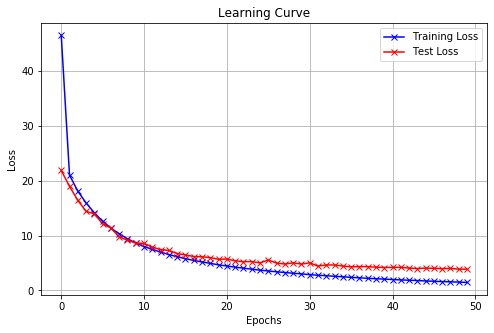

In [23]:
fig1 = plt.figure(figsize=(8, 5))
plt.plot(training_losses, marker='x', label="Training Loss", color="blue")
plt.plot(test_losses, marker='x', label="Test Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()
fig1.savefig('learning_curve.png', dpi=300)

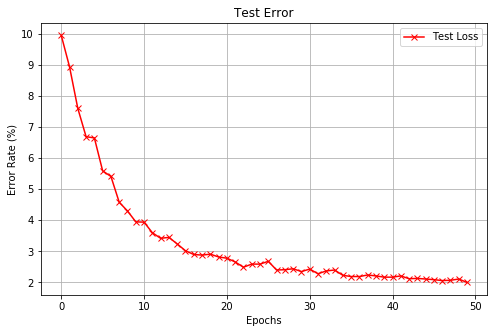

In [24]:
fig11 = plt.figure(figsize=(8, 5))
plt.plot(100*np.array(test_errors), marker='x', label="Test Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Error Rate (%)")
plt.title("Test Error")
plt.legend()
plt.grid(True)
plt.show()
fig11.savefig('test_error.png', dpi=300)

#### Q4 (3)

In [12]:
class PyTorchNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PyTorchNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [13]:
def model_test_torch(model_torch, dataset=testloader):
    correct_test = 0
    total_test = 0
    total_loss = 0
    for images, labels in dataset:
        images = images.view(images.shape[0], -1)
        outputs = model_torch.forward(images)
        predicted = torch.argmax(outputs, dim=1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        total_loss += criterion(outputs, labels).item()
    test_accuracy = correct_test / total_test
    test_error = 1 - test_accuracy
    # print(f"Accuracy: {100 * test_accuracy}%, Test Error: {100 * test_error}%")
    total_loss = total_loss/len(dataset)
    return test_error, total_loss

In [14]:
learning_rate = 0.1
epochs = 50
input_dim = 28*28
hidden_dim = 300
output_dim = 10

model_torch = PyTorchNN(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_torch.parameters(), lr=learning_rate)

training_losses_torch = []
test_losses_torch = []
test_errors_torch = []
for epoch in range(epochs):
    total_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()

        outputs = model_torch(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    training_losses_torch.append(total_loss/len(trainloader))
    test_error_torch, total_loss_torch = model_test_torch(model_torch)
    test_losses_torch.append(total_loss_torch)
    test_errors_torch.append(test_error_torch)
    print(f"Epoch {epoch+1}, Loss: {training_losses_torch[-1]}, Test Loss: {test_losses_torch[-1]}, Test Error: {100 * test_error_torch}%")


Epoch 1, Loss: 2.069412719720462, Test Loss: 1.9017784990322817, Test Error: 41.900000000000006%
Epoch 2, Loss: 1.7960494658840236, Test Loss: 1.737123427877001, Test Error: 24.850000000000005%
Epoch 3, Loss: 1.7293685182833722, Test Loss: 1.7163299360093038, Test Error: 24.19%
Epoch 4, Loss: 1.7165833246479156, Test Loss: 1.708701974267413, Test Error: 23.850000000000005%
Epoch 5, Loss: 1.7100957009329725, Test Loss: 1.7041102951499307, Test Error: 23.619999999999997%
Epoch 6, Loss: 1.701669652833105, Test Loss: 1.67607677666245, Test Error: 19.369999999999997%
Epoch 7, Loss: 1.660267722504988, Test Loss: 1.649158487654036, Test Error: 17.569999999999997%
Epoch 8, Loss: 1.6461549049247302, Test Loss: 1.641024338211983, Test Error: 16.92%
Epoch 9, Loss: 1.639488239278163, Test Loss: 1.635338611663527, Test Error: 16.490000000000006%
Epoch 10, Loss: 1.634912763704369, Test Loss: 1.632656961489635, Test Error: 16.33%
Epoch 11, Loss: 1.6316322989301133, Test Loss: 1.6286152730322188, Test

In [15]:
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in testloader:
        images = images.view(images.shape[0], -1)
        outputs = model_torch.forward(images)
        predicted = torch.argmax(outputs, dim=1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
test_accuracy = correct_test / total_test
test_error = 1 - test_accuracy

print(f"Accuracy: {100 * test_accuracy}%, Test Error: {100 * test_error}%")

Accuracy: 95.6%, Test Error: 4.400000000000004%


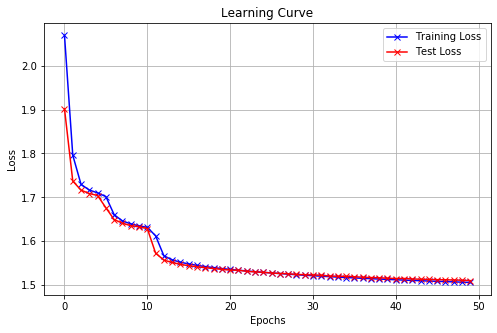

In [18]:
fig2 = plt.figure(figsize=(8, 5))
plt.plot(training_losses_torch, marker='x', label="Training Loss", color="blue")
plt.plot(test_losses_torch, marker='x', label="Test Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()
fig2.savefig('learning_curve_torch.png', dpi=300)

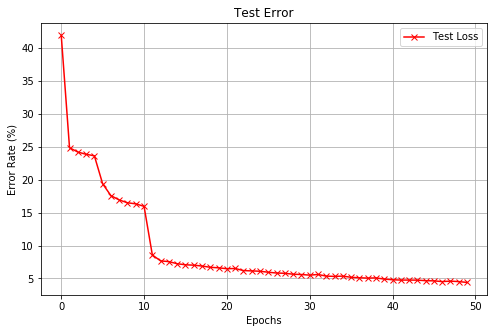

In [17]:
fig22 = plt.figure(figsize=(8, 5))
plt.plot(100*np.array(test_errors_torch), marker='x', label="Test Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Error Rate (%)")
plt.title("Test Error")
plt.legend()
plt.grid(True)
plt.show()
fig22.savefig('test_error_torch.png', dpi=300)